In [1]:
import sys
import os
sys.path.append(os.getcwd())
# sys.path.append(r"D:\workspace\SPECT_project\RadiSmart")
# sys.path.append(r"/home/liusheng/worksapce2024/Projects/RadiSmart")
# sys.path.append(r"/home/liusheng/worksapce2024/Projects/RadiSmart/cardiac/segment")


import os
import numpy as np
import SimpleITK as sitk
from scipy.ndimage import zoom

from cardiac.segment.advanced_segment import cal_lv_mask
# from cardiac.cadc_integrate import generate_bull_eye_image

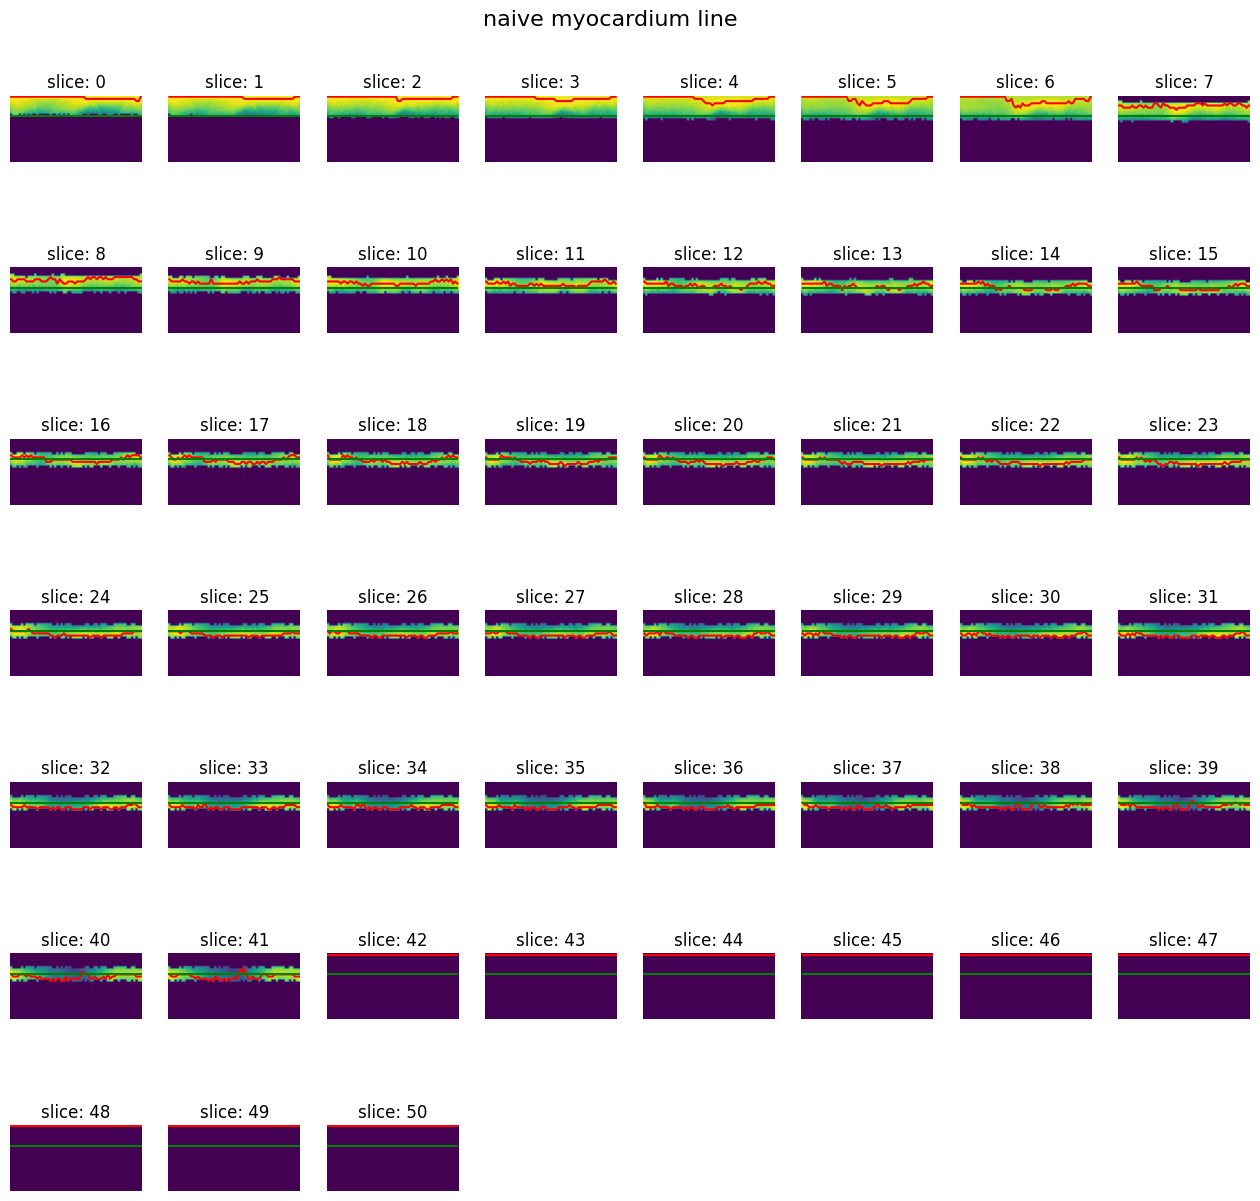

*******************************New param*******************************
True True False True
{
    "center": {
        "cy": 25.486672564083104,
        "cx": 27.94498200367791
    },
    "radius": 10.0,
    "apex_z": 4,
    "base_z": 39.15151515151515,
    "z_map": null,
    "dividing_z": 24.0
}
*******************************New param*******************************
True True True True
{
    "center": {
        "cy": 25.34241586168165,
        "cx": 27.47235848531006
    },
    "radius": 11.0,
    "apex_z": 4,
    "base_z": 37.86666666666667,
    "z_map": null,
    "dividing_z": 26.0
}


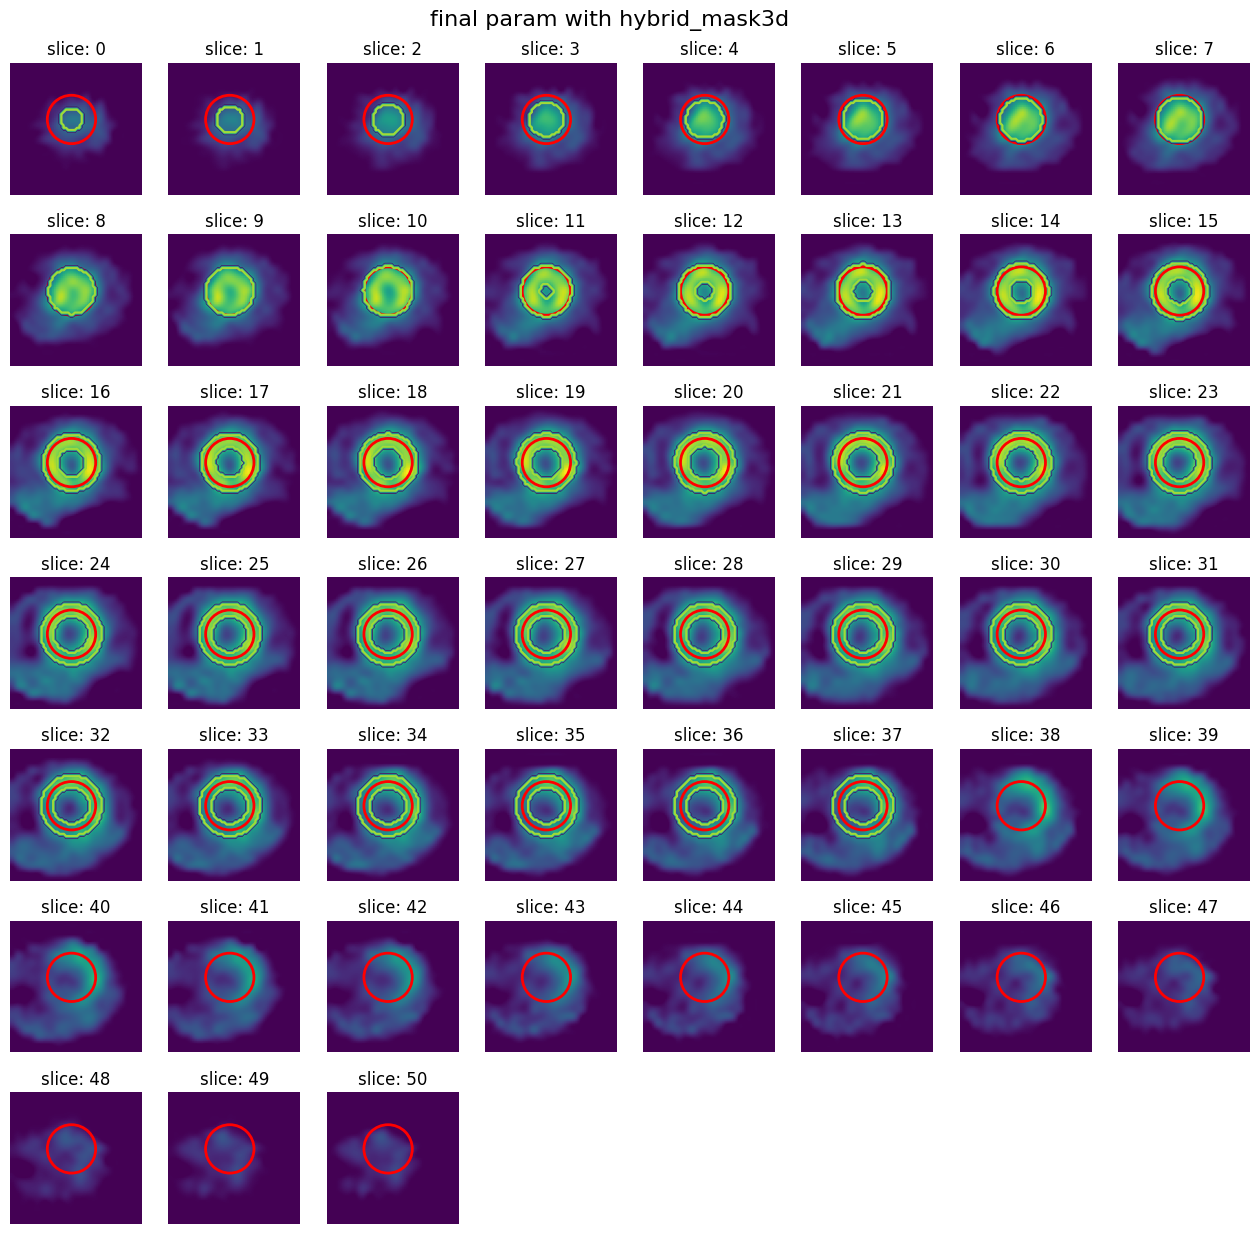

*******************************final_param_with_plane*******************************
{
    "center": {
        "cy": 25.34241586168165,
        "cx": 27.47235848531006
    },
    "radius": 11.0,
    "apex_z": 4,
    "base_z": 37.86666666666667,
    "z_map": null,
    "dividing_z": 26.0,
    "plane": {
        "a": 0.24370039682540437,
        "b": -0.1374007936507997,
        "c": -1,
        "d": 37.244841269841274
    },
    "angled_plane": {
        "37": [
            23,
            24,
            25,
            26,
            27,
            28,
            29
        ]
    }
}


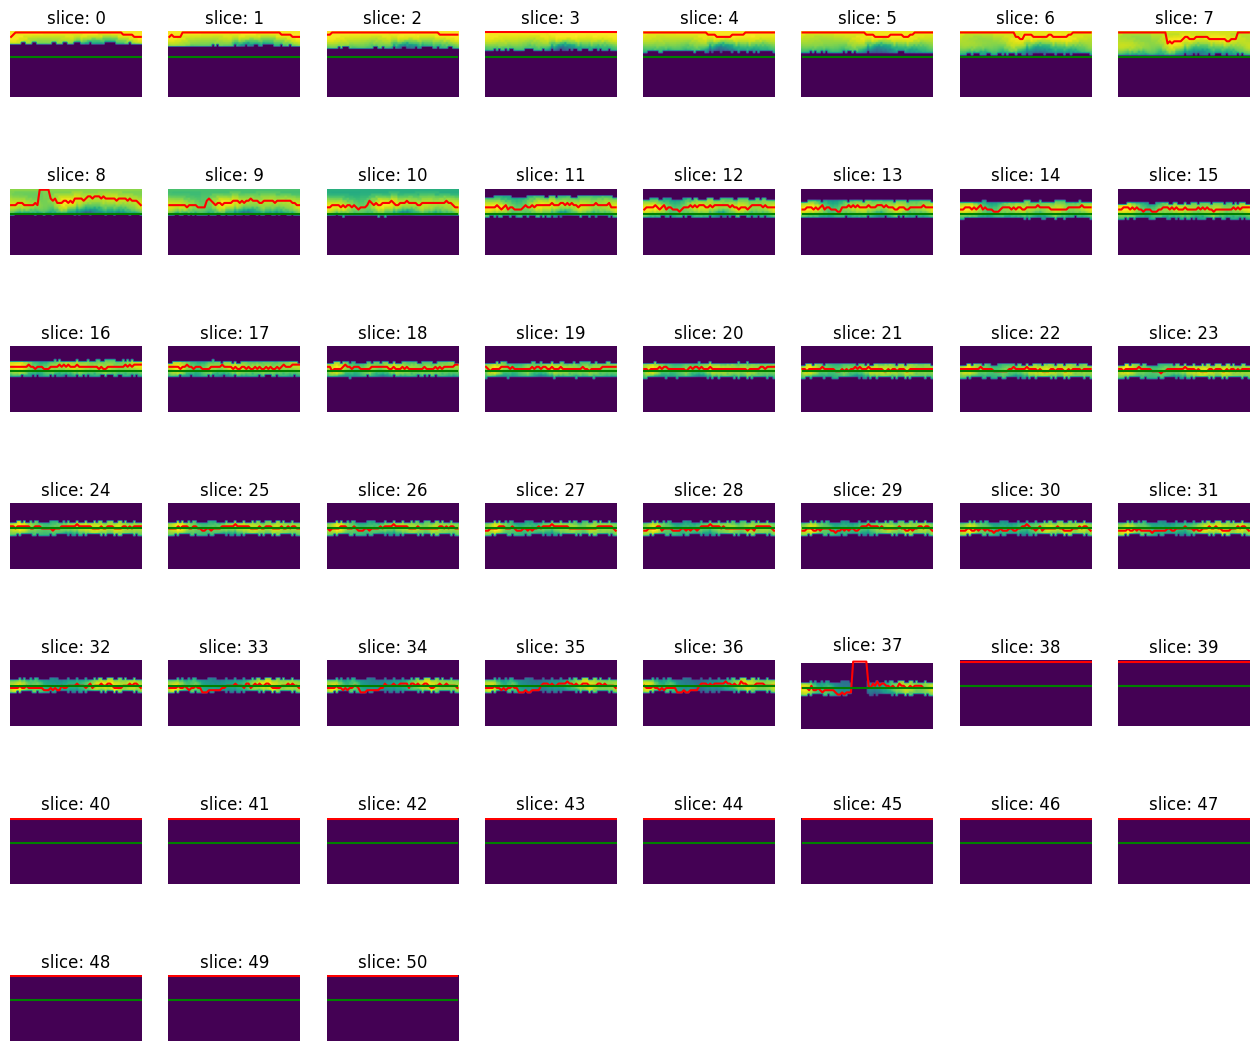

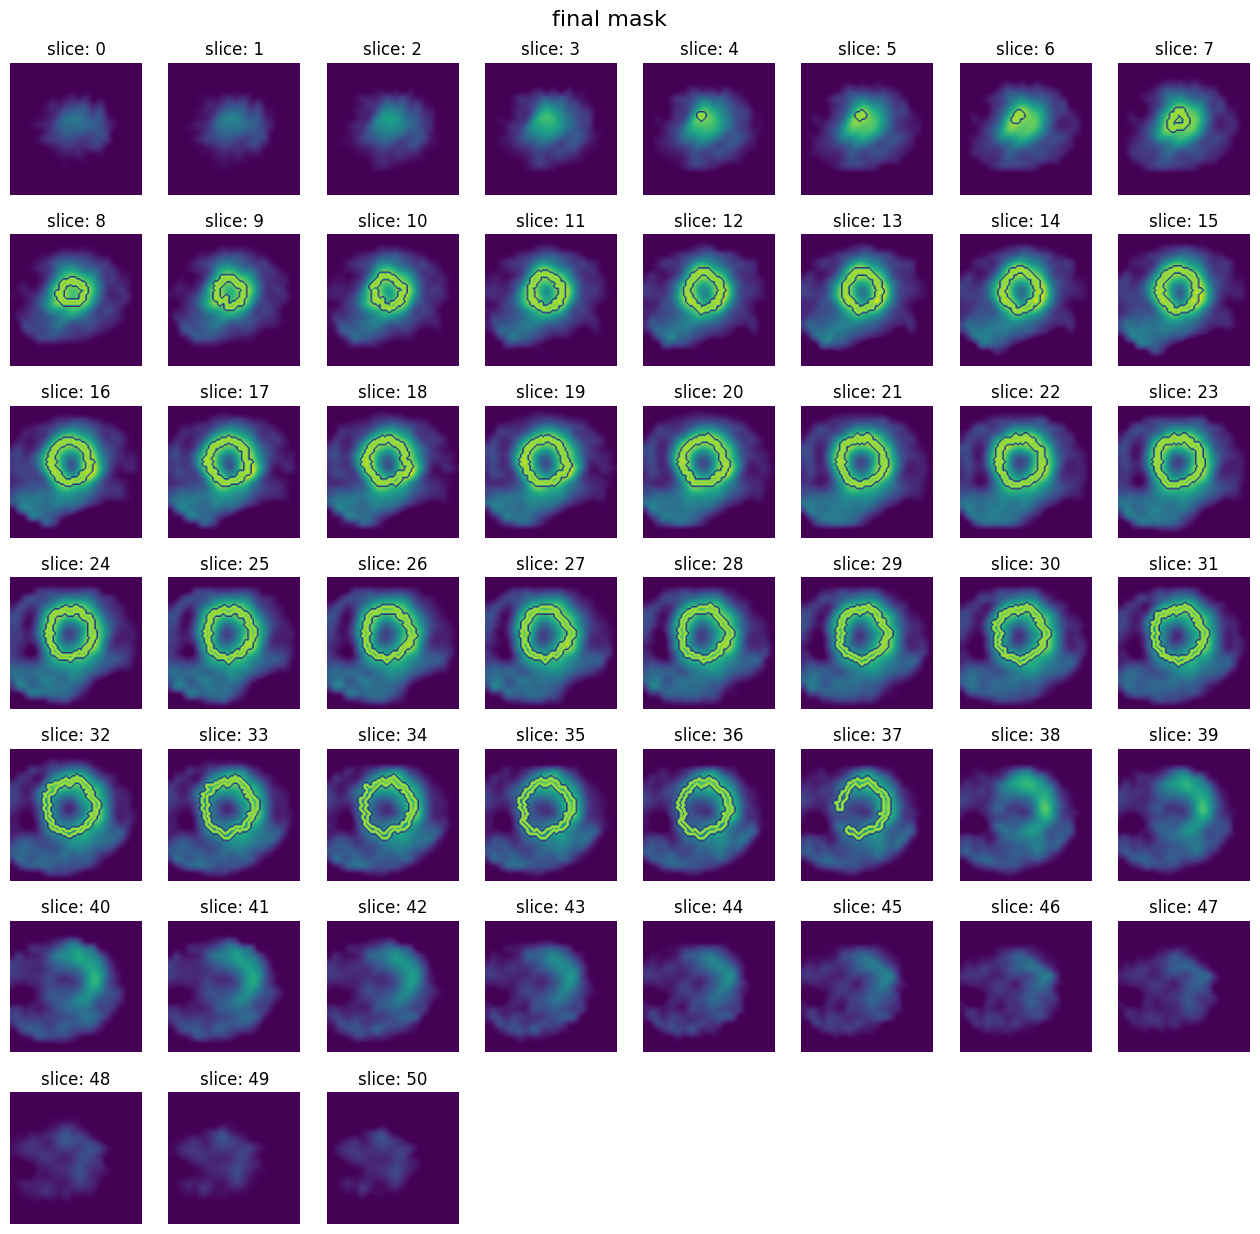

In [2]:
DATA_COLLECTION = "/mnt/labnas/DataCollection"
# DATA_COLLECTION = r"Y:\labspace\DataCollection"
# base_dir = os.path.join(DATA_COLLECTION, "Project", "RadiSmart", "cardiac", "healthy")
base_dir = os.path.join(DATA_COLLECTION, "Project", "RadiSmart", "cardiac", "demo")
img_path = os.path.join(base_dir, "000652515", "154")
# img_path = os.path.join(base_dir, "000149118", "101")
# img_path = os.path.join(base_dir, "002475009", "402")
# img_path = os.path.join(base_dir, "600860468", "997")
# img_path = os.path.join(base_dir, "600360681", "1081")

# demo list
# img_path = os.path.join(base_dir, "001398670", "263")


def read_sitk_img(path, zoom_factor = 3):
    sitk_img = sitk.ReadImage(path)
    img_arr = sitk.GetArrayFromImage(sitk_img)
    # SimpleITK: image[x,y,z]; numpy: image_numpy_array[z,y,x]
    # print(f"img meta: \n shape:{img_arr.shape} \n spacing:{sitk_img.GetSpacing()[::-1]}")
    width = 20
    # 计算中心位置
    center = np.array(img_arr.shape)//2
    start = center - width//2
    end = center + width//2
    
    clipped_img_arr = img_arr[:, start[1]:end[1], start[2]:end[2]].copy()
    
    zoomed_clipped_img_arr = zoom(clipped_img_arr, zoom_factor, cval=0)
    voxel_size = np.array(sitk_img.GetSpacing()[::-1])/zoom_factor
    return zoomed_clipped_img_arr, voxel_size

zoom_factor = 3
zoomed_clipped_non_gate_img3d, voxel_size = read_sitk_img(img_path, zoom_factor) 

lv_mask, param = cal_lv_mask(zoomed_clipped_non_gate_img3d, voxel_size, 2)
